In [2]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib.patches as mpatches


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [9]:
def readResultCSV(f):
    global data
    x1 = list()
    y1 = list()
    data = []
    with open(f, "r") as ins:
        for line in ins:
            tokens = line.split(',')
            data.append(line)
            x1.append(int(tokens[2]))
            y1.append(int(tokens[3]))
    return (x1, y1, data)

def runGPFlow(x1, y1):
    x2 = np.asarray(x1).astype('f')
    y2 = np.asarray(y1).astype('f')
    y2_scaled = y2 / y2.max()
    km_mattern = GPflow.kernels.Matern52(1, lengthscales=14*24.0)
    k_weekly = GPflow.kernels.PeriodicKernel(1, period=7*24.0)
    k_daily = GPflow.kernels.PeriodicKernel(1, period=24.0)
    k_daily.period.fixed = True
    k_weekly.period.fixed = True
    k = km_mattern * k_weekly * k_daily
    m = GPflow.gpr.GPR(x2[:,None], y2_scaled[:,None], kern=k)
    m.likelihood.variance = 0.002
    print(m.compute_log_likelihood())
    m.optimize()
    print(m.compute_log_likelihood())
    return m


def runGPFlowForMonth(x1, y1):
    x2 = np.asarray(x1).astype('f')
    y2 = np.asarray(y1).astype('f')
    y2_scaled = y2 / y2.max()
    km_mattern = GPflow.kernels.Matern52(1, lengthscales=12*24.0)
    k_weekly = GPflow.kernels.PeriodicKernel(1, period=7*24.0)
    k_daily = GPflow.kernels.PeriodicKernel(1, period=24.0)
    k_daily.period.fixed = True
    k_weekly.period.fixed = True
    k = km_mattern * k_daily * k_weekly
    m = GPflow.gpr.GPR(x2[:,None], y2_scaled[:,None], kern=k)
    m.likelihood.variance = 0.002
    print(m.compute_log_likelihood())
    m.optimize()
    print(m.compute_log_likelihood())
    return m
    
def plot(m, x1, y1):
    x2 = np.asarray(x1).astype('f')
    y2 = np.asarray(y1).astype('f')
    y2_scaled = y2 / y2.max()
    xx = np.linspace(x2.min(), x2.max(), 200)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(x2, y2_scaled, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.ylabel('Scaled Y label/Pickups')
    plt.xlabel('Incremental hourly index')
    plt.show()


def plotResiduals(m, x1, y1, threshold, data, month=None):
    x2 = np.asarray(x1).astype('f')
    y2 = np.asarray(y1).astype('f')
    y2_scaled = y2 / y2.max()
    mean, var = m.predict_y(x2[:,None])
    plt.plot(x2, y2_scaled - mean[:,0], 'kx', mew=0.5)
    plt.ylabel('Mean')
    plt.xlabel('Incremental hourly index')
    plt.show()
    if month is not None:
        plotMeanAgainstWeather(x2, y2_scaled - mean[:,0], month)
    
def plotOutliers(y2_scaled_wo_mean, threshold, data):
    residuals_x = []
    residuals_y = []
    for i in range(len(y2_scaled_wo_mean)):
        if(y2_scaled_wo_mean[i]) > threshold:
            print(y2_scaled_wo_mean[i], data[i])
            residuals_x.append(i)
            residuals_y.append(y2_scaled_wo_mean[i])
            



# COMPLETE ANALYSIS FOR 5 MONTHS

# MONTHLY ANALYSIS APRIL

In [4]:
def plotMeanAgainstWeather(x2, y2, month):
    weather_data = []
    x1_temp = []
    y1_temp = []
    preci = []
    with open("weather_6_mon.csv", "r") as ins:
        i=1
        for line in ins:
            if line.startswith(month):
                tokens = line.split(',')
                weather_data.append(line)
                #x1_temp.append(int(tokens[2]))
                x1_temp.append(int(i))
                y1_temp.append(float(tokens[3]))
                if(tokens[4] == "T"):
                    preci.append(0.01)
                else:
                    preci.append(float(tokens[4]))
                i+=1   
    y1_temp = np.array(y1_temp)
    preci = np.array(preci)    
    plt.plot(x1_temp, y1_temp / y1_temp.max() - 0.725, mew=2)
    x2_new, y2_new = reduceHoursToDays(x2,y2)
    plt.plot(x2_new, y2_new, mew=0.5)
    plt.plot(x1_temp, preci / preci.max())
    plt.xlim(1,31)
    plt.ylim(-0.5,0.5)
    plt.xlabel('Incremental hourly index')
    plt.ylabel('Mean')
    weather_patch=mpatches.Patch(color='#e27362', label='weather')
    pickups_patch=mpatches.Patch(color='#a59dd8', label='Pickups')
    prec_patch=mpatches.Patch(color='#62a1c7', label='Precipitation')
    plt.legend(handles=[weather_patch,pickups_patch,prec_patch], loc=4, prop={'size':6})
    plt.show()
    

def reduceHoursToDays(x, y):
    days = []
    i = 1
    count = 0.0
    new_means = []
    new_x = []
    x = 1
    for mean in y:
        if i%24 == 0:
            new_means.append(count)
            count = 0.0
            new_x.append(x)
            x += 1
        else:
            count+=mean        
        i+=1

    return (new_x,new_means)

In [13]:
(x1_april, y1_april,data) = readResultCSV('result_april.csv')
model = runGPFlowForMonth(x1_april, y1_april)

930.295404672
1123.48285152


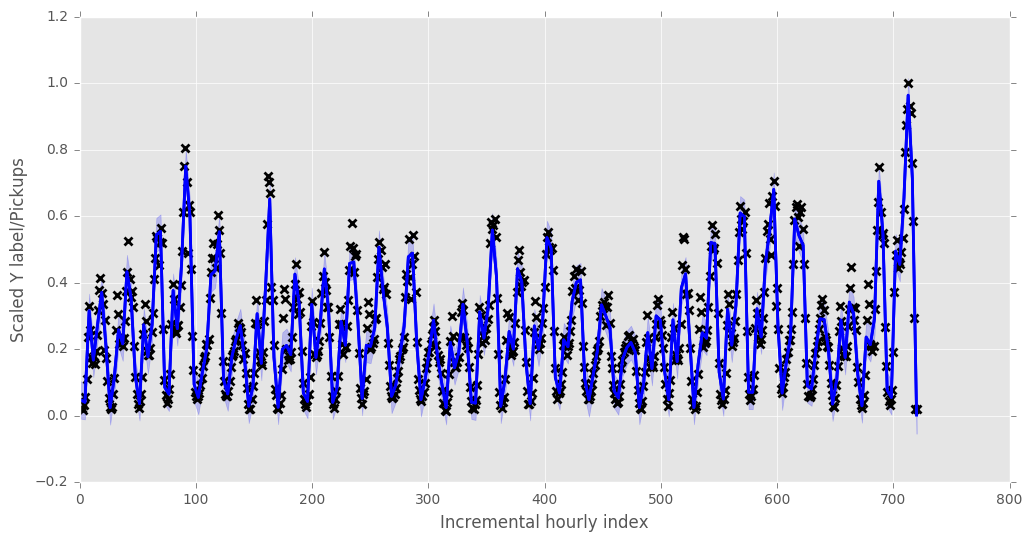

In [14]:
mean = plot(model,x1_april, y1_april)

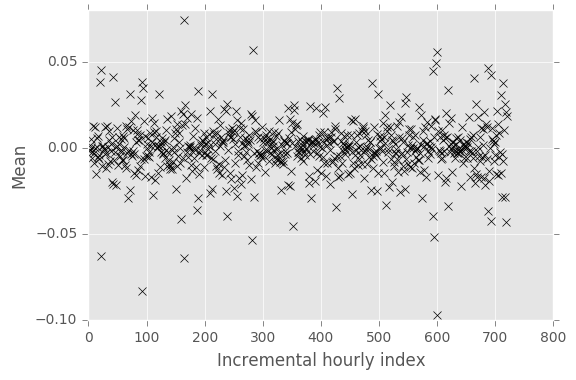

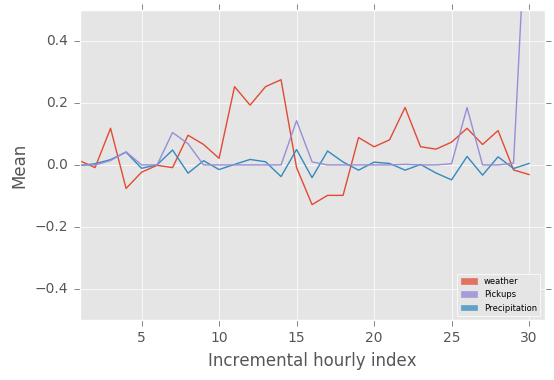

In [15]:
plotResiduals(model, x1_april, y1_april, 0.05, data, '2014-04')

In [16]:
(x1_may, y1_may, mean) = readResultCSV('result_may.csv')
model = runGPFlowForMonth(x1_may, y1_may)

937.594585741
1125.12361674


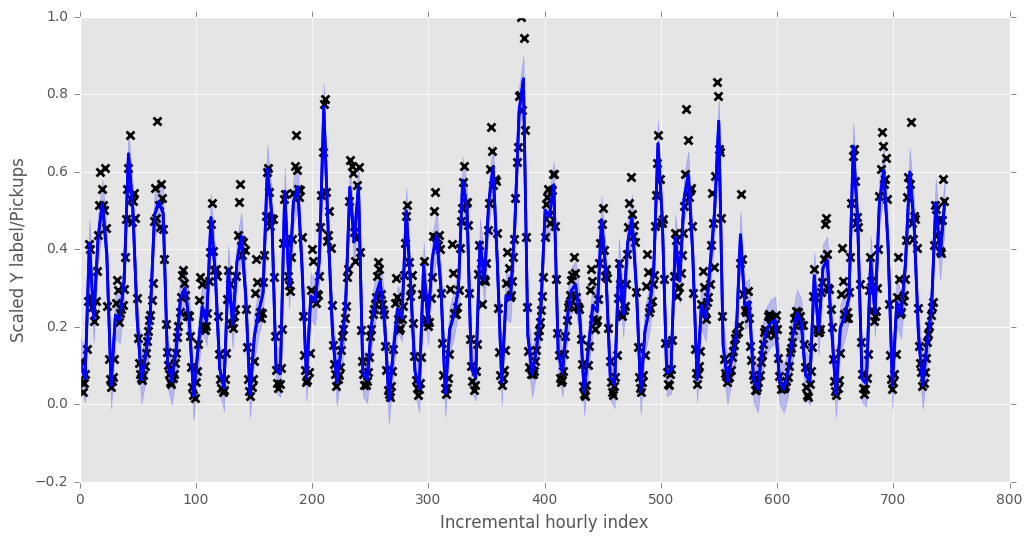

In [17]:
plot(model, x1_may, y1_may)

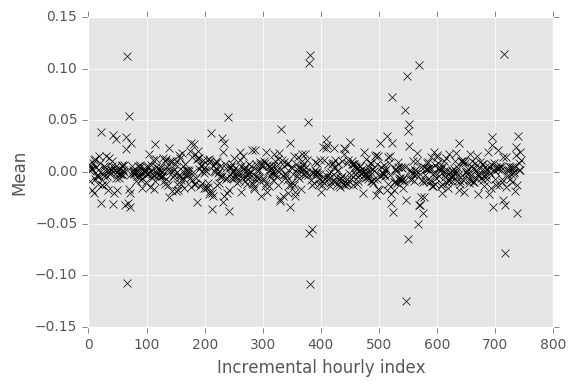

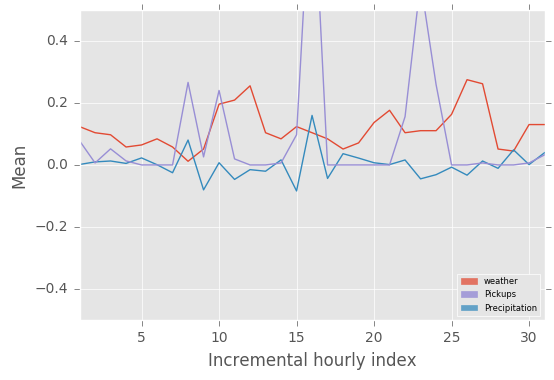

In [18]:
plotResiduals(model, x1_may, y1_may, 0.10, data, '2014-05')

In [19]:
(x1_jun, y1_jun, data) = readResultCSV('result_jun.csv')
model = runGPFlowForMonth(x1_jun, y1_jun)

907.746699415
1170.80212199


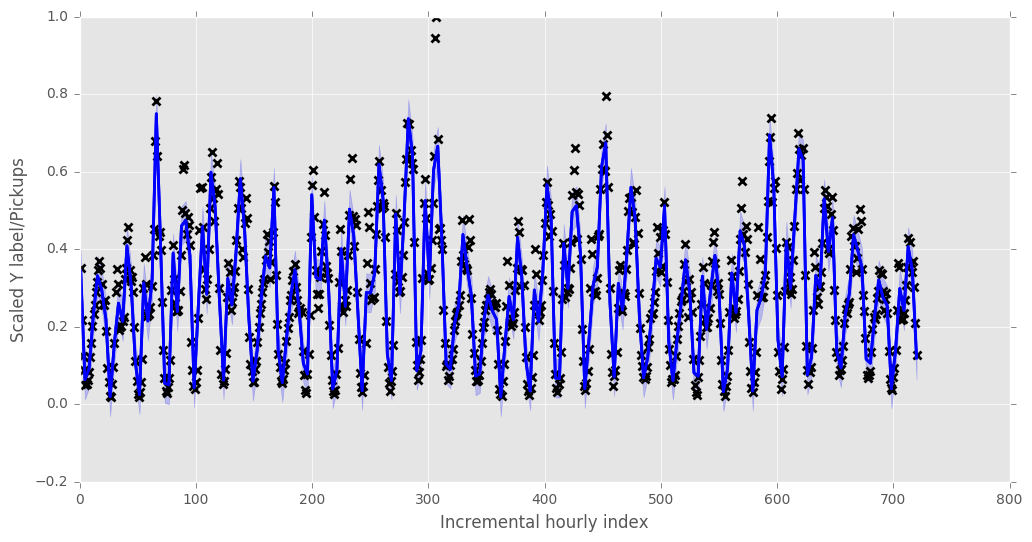

In [22]:
plot(model,x1_jun, y1_jun)

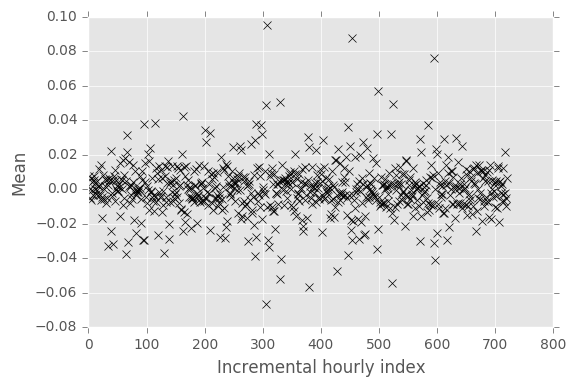

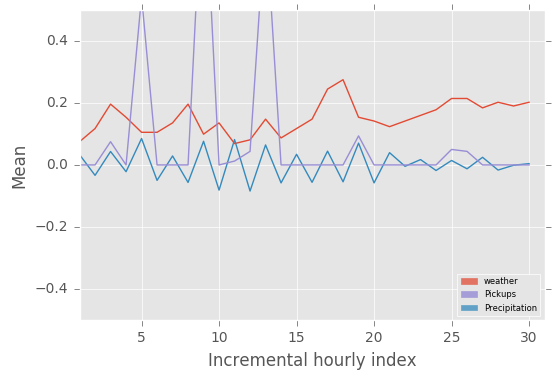

In [21]:
plotResiduals(model, x1_jun, y1_jun, 0.06, data,'2014-06')

In [23]:
(x1_jul, y1_jul, data) = readResultCSV('result_jul.csv')
model = runGPFlowForMonth(x1_jul, y1_jul)

1024.32399424
1208.19648126


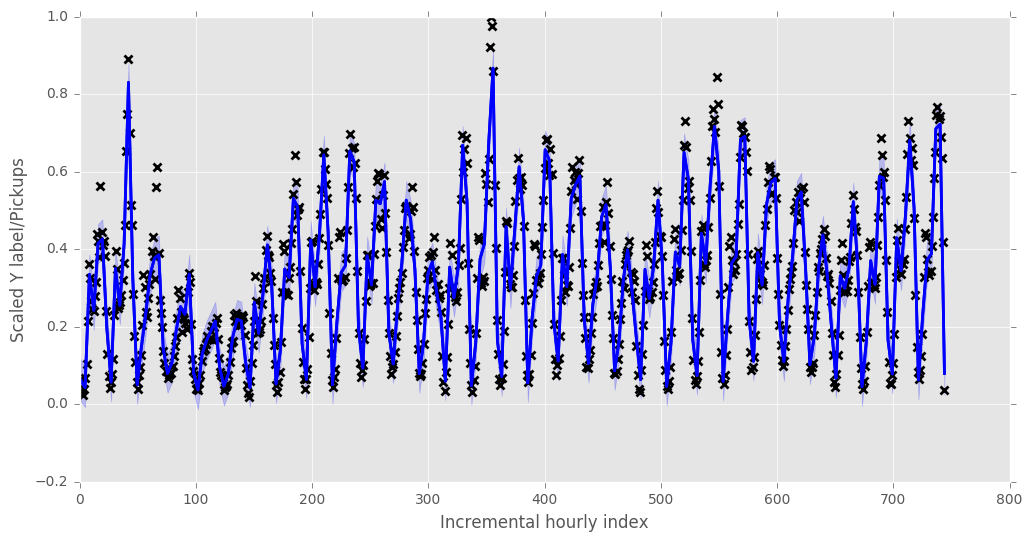

In [24]:
plot(model,x1_jul, y1_jul)

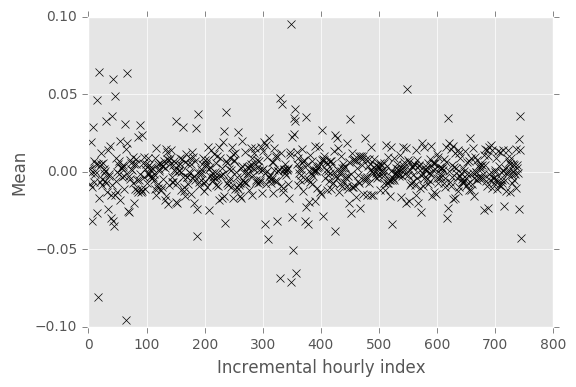

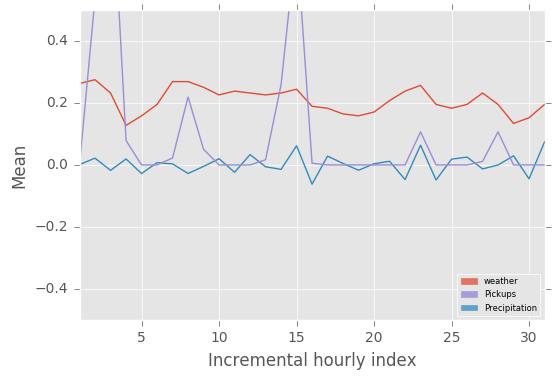

In [25]:
plotResiduals(model, x1_jul, y1_jul, 0.4, data,'2014-07')

In [26]:
(x1_aug, y1_aug, data) = readResultCSV('result_aug.csv')
model = runGPFlowForMonth(x1_aug, y1_aug)

1069.62382621
1350.63860841


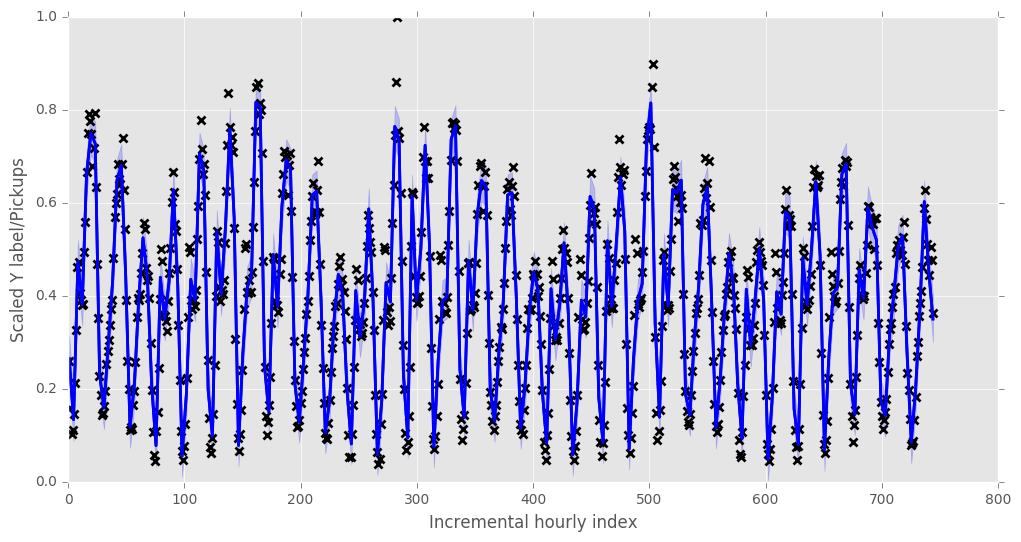

In [27]:
plot(model,x1_aug, y1_aug)

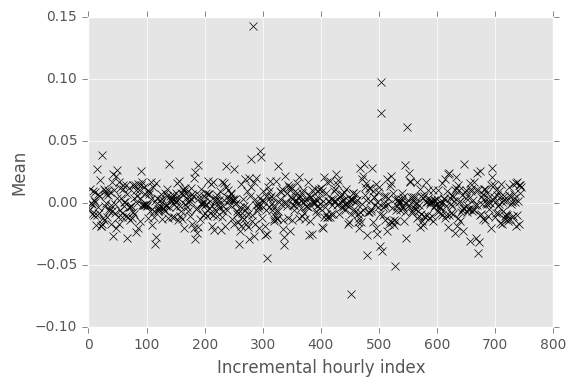

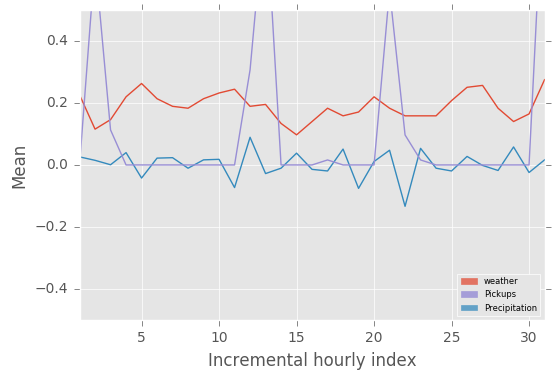

In [28]:
plotResiduals(model, x1_aug, y1_aug, 0.05, data, '2014-08')

In [30]:
(x1_sep, y1_sep, data) = readResultCSV('result_sep.csv')
model = runGPFlowForMonth(x1_sep, y1_sep)

1010.55006295
1241.8715872


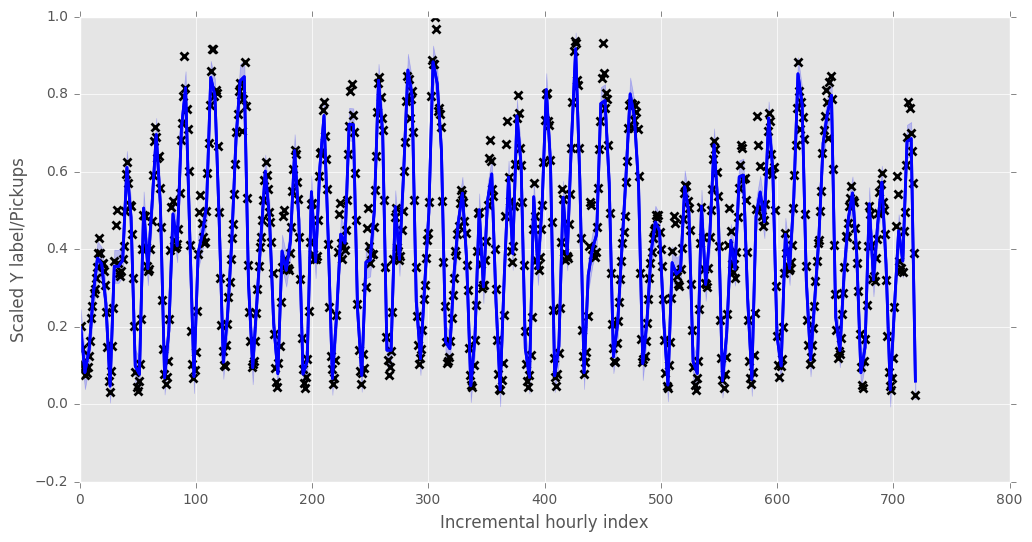

In [31]:
plot(model,x1_sep, y1_sep)

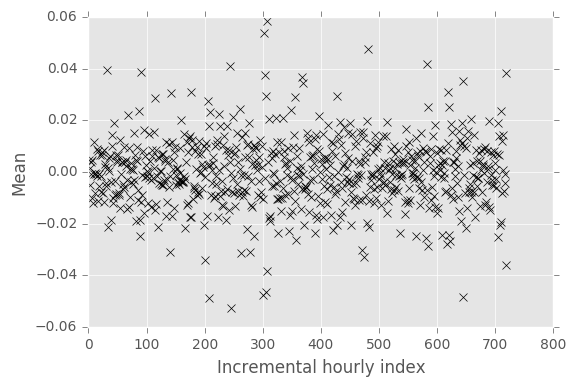

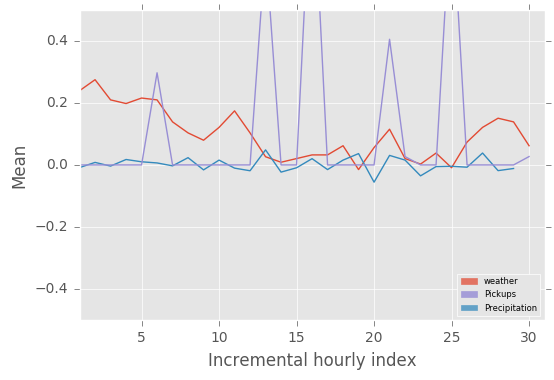

In [32]:
plotResiduals(model, x1_sep, y1_sep, 0.05, data, '2014-09')

In [35]:
(x1, y1, data) = readResultCSV('results_6_months.csv')
model = runGPFlow(x1, y1)

6244.37952816
7437.41144465


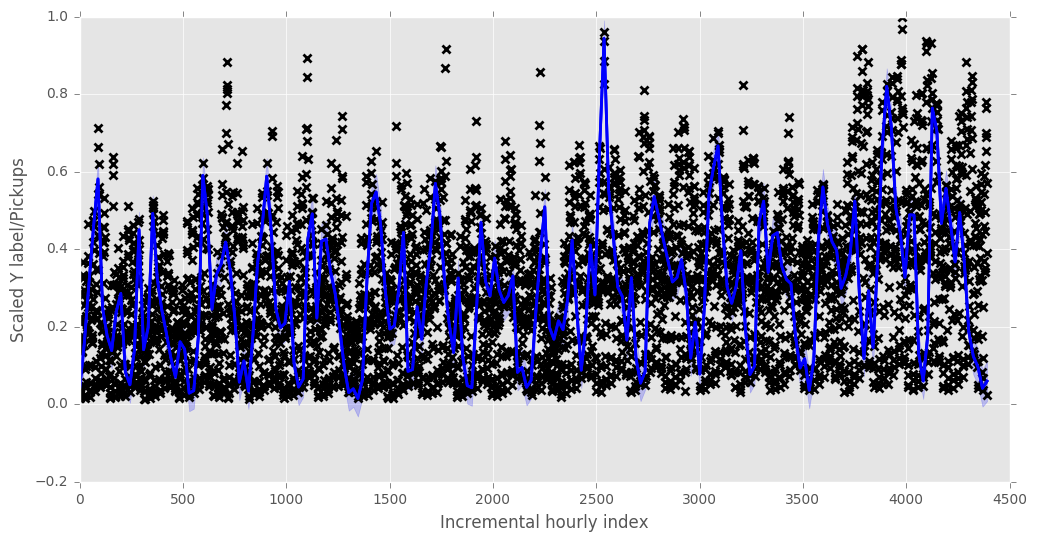

In [36]:
plot(model,x1, y1)

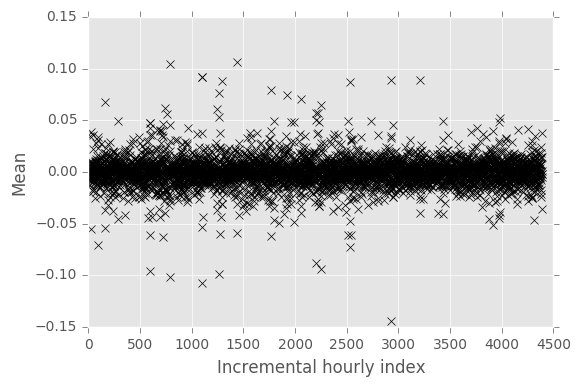

In [37]:
plotResiduals(model, x1, y1, 0.07, data)